# Democracy and Autocracy

Most people would prefer to live in a democratic country where rulers are elected and accountable to the people, rather than an autocratic country where rulers have unlimited power.
And most people value individual liberties like freedom of expression and freedom of association.

Before 1900, democracy and liberty were rare: most countries were "closed autocracies" where citizens had no right to vote.
But that changed dramatically over the last 100 years.

The following figure shows the percentage of countries in each of four categories defined by the [Regimes of the World (RoW) project](https://www.cogitatiopress.com/politicsandgovernance/article/view/1214).

<img src="https://raw.githubusercontent.com/AllenDowney/DataWorld/main/figs/countries-democracies-autocracies-row.png">

This figure is from Our World in Data, which collects the data and makes it available for download.
They summarize the categories like this.

>* In _closed autocracies_, citizens do not have the right to either choose the chief executive of the government or the legislature through multi-party elections.
>
>* In _electoral autocracies_, citizens have the right to choose the chief executive and the legislature through multi-party elections; but they lack some freedoms, such as the freedoms of association or expression, that make the elections meaningful, free, and fair.
>
>* In _electoral democracies_, citizens have the right to participate in meaningful, free and fair, and multi-party elections.
>
>* In _liberal demoracies_, citizens have further individual and minority rights, are equal before the law, and the actions of the executive are constrained by the legislature and the courts.

Although the number of democratic countries has increased greatly over the last 100 years, it has decreased somewhat over the last 10 year.
To explore these trends, let's look more closely at the data.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataWorld/blob/main/nb/XXX.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataWorld/raw/main/nb/utils.py')

'utils.py'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate, value_counts

In [5]:
%load_ext nb_black

<IPython.core.display.Javascript object>

## Data



In [30]:
base_url = "https://ourworldindata.org/grapher/political-regime"

params = {
    "v": "1",
    "csvType": "full",
    "useColumnShortNames": "true",
}

headers = {"User-Agent": "Our World In Data data fetch/1.0"}

<IPython.core.display.Javascript object>

In [21]:
import requests
from urllib.parse import urlencode

url = f"{base_url}.csv?{urlencode(params)}"
df = pd.read_csv(url, storage_options=headers)

<IPython.core.display.Javascript object>

In [22]:
df = df.query("Year >= 1900")
df.head()

,Entity,Code,Year,regime_row_owid
111,Afghanistan,AFG,1900,0
112,Afghanistan,AFG,1901,0
113,Afghanistan,AFG,1902,0
114,Afghanistan,AFG,1903,0
115,Afghanistan,AFG,1904,0


<IPython.core.display.Javascript object>

In [23]:
url = f"{base_url}.metadata.json"
response = requests.get(url, params=params, headers=headers)
metadata = response.json()

<IPython.core.display.Javascript object>

In [24]:
from pprint import pprint

metadata_col = metadata["columns"]["regime_row_owid"]
pprint(metadata_col["citationLong"])

('V-Dem (2024) – processed by Our World in Data. “Political regime” [dataset]. '
 'V-Dem, “V-Dem Country-Year (Full + Others) v14” [original data].')


<IPython.core.display.Javascript object>

In [25]:
t = metadata_col["descriptionKey"]
print("\n\n".join(t))

The indicator uses the Regimes of the World classification by political scientists Anna Lührmann, Marcus Tannenberg and Staffan Lindberg.

The classification distinguishes between closed autocracies (score 0), electoral autocracies (score 1), electoral democracies (score 2), and liberal democracies (score 3).

In _closed autocracies_, citizens do not have the right to either choose the chief executive of the government or the legislature through multi-party elections.

In _electoral autocracies_, citizens have the right to choose the chief executive and the legislature through multi-party elections; but they lack some freedoms, such as the freedoms of association or expression, that make the elections meaningful, free, and fair.

In _electoral democracies_, citizens have the right to participate in meaningful, free and fair, and multi-party elections.

In _liberal demoracies_, citizens have further individual and minority rights, are equal before the law, and the actions of the executi

<IPython.core.display.Javascript object>

In [26]:
data = df.set_index(["Entity", "Year"])["regime_row_owid"].unstack()
data.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       ...
       'Vanuatu', 'Venezuela', 'Vietnam', 'West Germany', 'Yemen',
       'Yemen Arab Republic', 'Yemen People's Republic', 'Zambia', 'Zanzibar',
       'Zimbabwe'],
      dtype='object', name='Entity', length=186)

<IPython.core.display.Javascript object>

In [27]:
data.columns

Index([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909,
       ...
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int64', name='Year', length=124)

<IPython.core.display.Javascript object>

## Recent Changes

In [32]:
# we'll use these lists to translate between the integer codes
# in the DataFrame and the names of the categories

codes = [0, 1, 2, 3]

categories = [
    "closed autocracy",
    "electoral autocracy",
    "electoral democracy",
    "liberal democracy",
]

<IPython.core.display.Javascript object>

In [37]:
def columnwise_counts(data):
    """Compute a DataFrame that contains value counts for each column.

    data: DataFrame with one row per country, one column per year

    returns: DataFrame with one row per value, one column per year
    """
    counts = pd.DataFrame(index=codes, columns=data.columns)
    for year in data.columns:
        counts[year] = data[year].value_counts()
    return counts

<IPython.core.display.Javascript object>

In [39]:
counts = columnwise_counts(data)

<IPython.core.display.Javascript object>

In [40]:
year2 = 2023
counts[year2].to_frame()

,2023
0,34
1,54
2,59
3,32


<IPython.core.display.Javascript object>

In [47]:
from utils import underride


def plot_counts(counts, year, **options):
    """Horizontal bar chart of counts during a single year.

    counts: DataFrame
    year: integer
    options: passed to plot()
    """
    underride(options, alpha=0.6)
    counts[year].plot(kind="barh", **options)
    plt.yticks(codes, categories)
    decorate(xlabel="Number of countries", ylabel="Category")

<IPython.core.display.Javascript object>

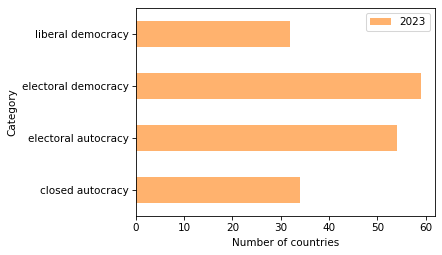

<IPython.core.display.Javascript object>

In [48]:
plot_counts(counts, year2, color="C1")

The most common regime type is electoral democracy, followed by electoral autocracy.

Let's compare the distribution of regime types in 2023 to the distribution 10 years ago, roughly at the high point of democracy.

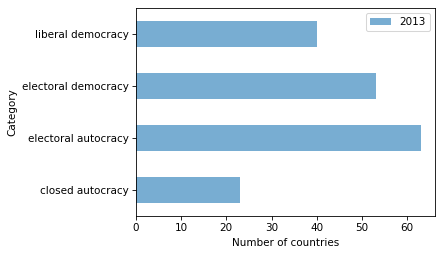

<IPython.core.display.Javascript object>

In [49]:
year1 = 2013
plot_counts(counts, year1)

It is easier to compare the distributions if we plot them on the same axes.

In [51]:
def two_bar_plots(dist1, dist2, width=0.45, **options):
    """ """
    underride(options, alpha=0.6)
    dist1.plot(kind="barh", color="C0", align="edge", width=width, **options)
    dist2.plot(kind="barh", color="C1", align="edge", width=-width, **options)

<IPython.core.display.Javascript object>

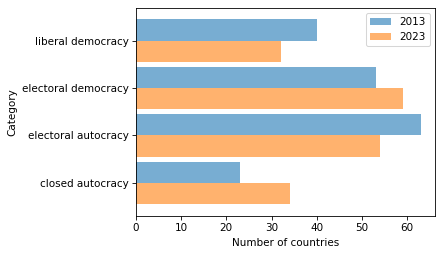

<IPython.core.display.Javascript object>

In [52]:
two_bar_plots(counts[year1], counts[year2])
plt.yticks(codes, categories)
decorate(xlabel="Number of countries", ylabel="Category", ylim=[-0.7, 3.7])

Now we can see the differences more clearly:

* The numbers of liberal democracies (3) and electoral autocracies (1) have decreased.

* The numbers of electoral democracies (2) and closed autocracies (0) have increased.

These results suggest that some liberal democracies have become electoral democracies (3 to 2) and some electoral autocracies have become close autocracies (1 to 0).

To see whether that interpretation is correct, we can make a table that shows the number of countries that made a transition from one category to another between 2013 and 2023.

In [63]:
def make_transitions(data, year1, year2):
    """Number of countries that transitioned from one category to another.

    data: DataFrame
    year1: start year
    year2: end year
    """
    labels = categories
    transitions = pd.crosstab(data[year1], data[year2])
    transitions.index = pd.Index(labels, name=year1)
    transitions.columns = pd.Index(labels, name=year2)
    return transitions

<IPython.core.display.Javascript object>

In [64]:
transitions = make_transitions(data, year1, year2)
transitions

2023,closed autocracy,electoral autocracy,electoral democracy,liberal democracy
2013,,,,
closed autocracy,19,3,1,0
electoral autocracy,12,40,10,1
electoral democracy,3,10,36,4
liberal democracy,0,1,12,27


<IPython.core.display.Javascript object>

The largest values are on the diagonal, which means that most countries stayed in the same category. For example, of 23 closed autocracies in 2013, 19 were unchanged in 2023, three became electoral autocracies, and one leaped all the way to an electoral democracy (Fiji) .

At the other end of the range, of 40 liberal democracies, 12 became electoral democracies and one regressed to an electoral autocracy (Mauritius).

In [65]:
import seaborn as sns


def plot_transitions(transitions):
    sns.heatmap(
        transitions,
        annot=True,
        annot_kws={"size": 14},
        fmt="d",
        cmap="YlGnBu",
        cbar=False,
    )
    plt.xticks(rotation=30)

<IPython.core.display.Javascript object>

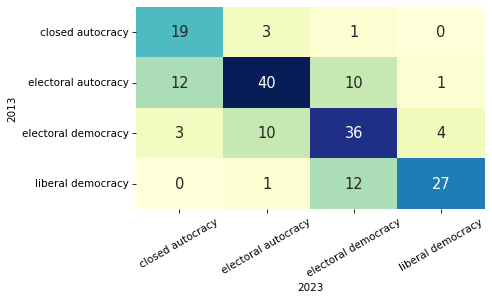

<IPython.core.display.Javascript object>

In [66]:
plot_transitions(transitions)

In [67]:
def find_transitions(data, year1, year2, val1, val2):
    """
    """
    before = data[year1] == val1
    after = data[year2] == val2
    return data.loc[before & after, year1:year2]

<IPython.core.display.Javascript object>

In [68]:
find_transitions(data, year1, year2, 3, 1)

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Entity,,,,,,,,,,,
Mauritius,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0


<IPython.core.display.Javascript object>

In [69]:
find_transitions(data, year1, year2, 0, 2)

Year,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Entity,,,,,,,,,,,
Fiji,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


<IPython.core.display.Javascript object>

## Plotting Over Time

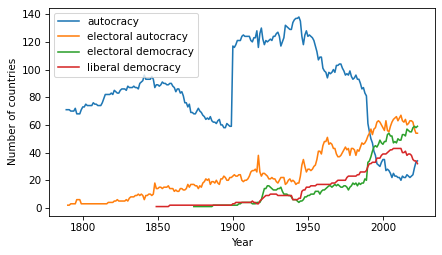

<IPython.core.display.Javascript object>

In [159]:
count_series = counts.transpose()
count_series.columns = pd.Index(categories)
count_series.plot()
decorate(ylabel="Number of countries")

<Axes: xlabel='Year'>

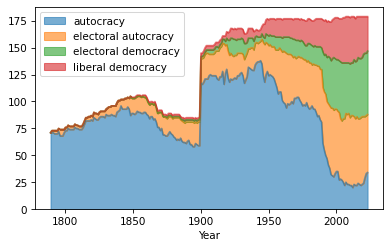

<IPython.core.display.Javascript object>

In [154]:
count_series.plot.area(alpha=0.6)

In [155]:
count_series_normalized = count_series.div(count_series.sum(axis=1), axis=0) * 100
count_series_normalized.tail()

,autocracy,electoral autocracy,electoral democracy,liberal democracy
Year,,,,
2019,12.849162,35.195531,30.726257,21.229050
2020,13.407821,34.636872,32.402235,19.553073
2021,16.201117,31.843575,32.960894,18.994413
2022,18.435754,30.167598,32.402235,18.994413
2023,18.994413,30.167598,32.960894,17.877095


<IPython.core.display.Javascript object>

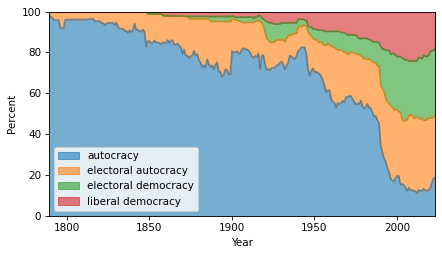

<IPython.core.display.Javascript object>

In [160]:
count_series_normalized.plot.area(alpha=0.6)
xlim = count_series_normalized.index.min(), count_series_normalized.index.max()
decorate(ylabel="Percent", xlim=xlim, ylim=[0, 100])

In [129]:
year0 = 1923
counts[year0]

0    120
1     23
2     16
3      9
Name: 1923, dtype: int64

<IPython.core.display.Javascript object>

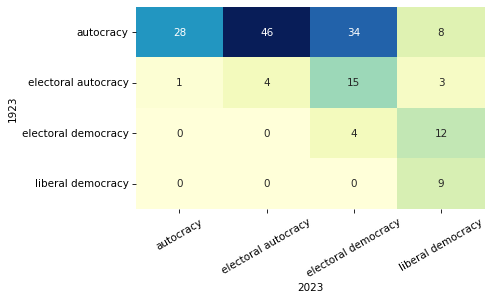

<IPython.core.display.Javascript object>

In [128]:
year0 = 1923
year2 = 2023

transitions100 = make_transitions(data, year0, year2)
plot_transitions(transitions100)

In [ ]:
make_transitions(data, year0, year2)

More reading: Herre, "[The world has recently become less democratic](https://ourworldindata.org/less-democratic)", 2022.

[*Data World: Understanding Our World With Data*](https://allendowney.github.io/DataWorld/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)